In [1]:
%pylab inline
import time
import ete3
from Bio import Phylo
from io import StringIO
from matplotlib import cm
from importlib import reload
import epistasis_methods as em
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


# Random Epistatic Landscapes With Diversity
At each time step we pick one active leaf and find the next $\mu$ and thereby the $s$ characterizing a step from this branch. 

In [2]:
def D_func(x):
    return abs(x)**.5

In [3]:
reload(em)

N = 50
RE = em.RandomEvo(N,D_func,seed=1)
RE.run_evo()

Text(0, 0.5, 'mean fitness')

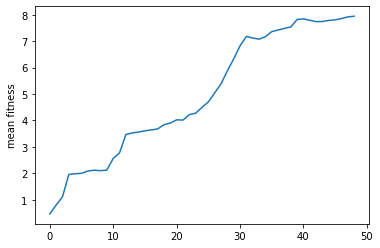

In [4]:
plot(RE.mean_s_traj)
ylabel('mean fitness')

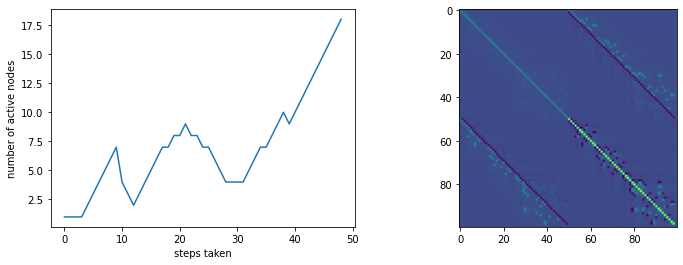

In [5]:
figure(figsize=(12,4))
subplot(1,2,1)
plot(RE.num_active_traj)
ylabel('number of active nodes')
xlabel('steps taken')

subplot(1,2,2)
imshow(RE.cov_mat)

# Plotting with Bio Phylo

In [6]:
viridis = cm.get_cmap('viridis', 256)
color_dict = {}
for i,x in enumerate(RE.tree.nodes):
    color_dict[x] = viridis(i/N)

In [7]:
tree_string = RE.tree.get_newick()
handle = StringIO(tree_string)
T = Phylo.read(handle,'newick')
T.ladderize()

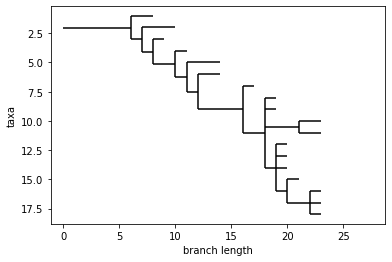

In [8]:
Phylo.draw(T,label_func=lambda x:None,branch_labels=lambda x:None,label_colors=color_dict)

# Plotting with ETE3

In [31]:
tree_string = RE.tree.get_newick()
T = ete3.Tree(tree_string,format=1)
color_dict = {}
for i,x in enumerate(RE.tree.nodes):
    color_dict[str(x)] = i/N

In [32]:
TS = ete3.TreeStyle()
TS.scale=4
TS.branch_vertical_margin=4
TS.show_leaf_name=False

In [33]:
rbow=cm.get_cmap('rainbow')

for n in T.traverse():
    nstyle=ete3.NodeStyle()
    nstyle["size"]=1
    if n.name!='root':
        nstyle["hz_line_color"]=matplotlib.colors.to_hex(rbow(color_dict[n.name]))
        nstyle["vt_line_color"]=matplotlib.colors.to_hex(rbow(color_dict[n.name]))
    nstyle["hz_line_width"]=3
    nstyle["vt_line_width"]=3
    n.set_style(nstyle)
# phylo.convert_to_ultrametric()
T.ladderize()
T.render('epistasis.pdf',tree_style=TS);

# Approximating power by sum of exponentials

In [9]:
def sum_exp(x,*params):
    L = len(params)
    assert L%2==0
    coeffs = params[:L//2]
    lens = params[L//2:]
    return sum([coeffs[i]*(1-exp(-x/l)) for i,l in enumerate(lens)],axis=0)

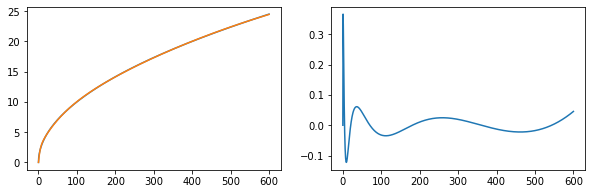

In [71]:
xtest = linspace(0,600,1000)

xfit = linspace(0,600,1000)
alpha = 0.5
y = xfit**alpha

popt,_ = curve_fit(sum_exp,xfit,y,p0=ones(2*3))

figure(figsize=[10,3])
subplot(1,2,1)
plot(xtest,xtest**alpha)
plot(xtest,sum_exp(xtest,*popt))
subplot(1,2,2)
plot(xtest,xtest**alpha-sum_exp(xtest,*popt))

In [77]:
# parameters for alpha = 0.5
pstar = popt

def D_func1(x):
    return abs(x)**.5

def D_func2(x):
    return sum_exp(abs(x),*pstar)

In [78]:
reload(em)

N = 100
RE1 = em.RandomEvo(N,D_func1,seed=2)
RE1.run_evo()

RE2 = em.RandomEvo(N,D_func2,seed=2)
RE2.run_evo()

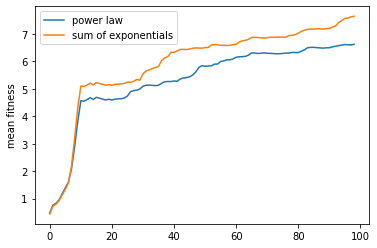

In [79]:
plot(RE1.mean_s_traj,label='power law')
plot(RE2.mean_s_traj,label='sum of exponentials')

ylabel('mean fitness')
legend()

## Only condition on parent

In [80]:
L = len(pstar)
coeff_list = pstar[:L//2]
corr_len_list = pstar[L//2:]

In [81]:
reload(em)
RE = em.RandomEvo_Exp(coeff_list,corr_len_list,seed=2)
RE.run_evo(3000)

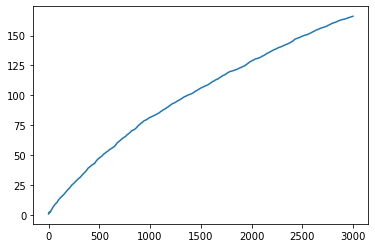

In [82]:
plot(RE.mean_s_traj)

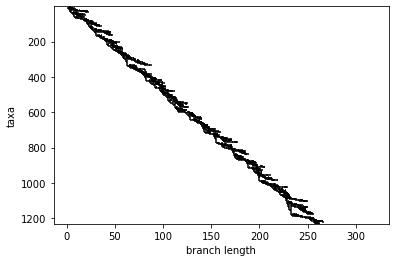

In [83]:
tree_string = RE.tree.get_newick()
handle = StringIO(tree_string)
T = Phylo.read(handle,'newick')
T.ladderize()

Phylo.draw(T,label_func=lambda x:None,branch_labels=lambda x:None,label_colors=color_dict)

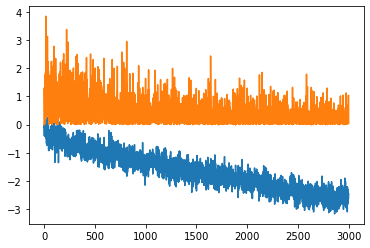

In [86]:
plot([sum(RE.labels[k][0]) for k in range(3000)])
plot([sum(RE.labels[k][1]) for k in range(3000)])